In [1]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow as pa
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
!pip install feather-format >> none
!pip3 install faiss-cpu --no-cache
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 31.3 MB/s eta 0:00:00


In [4]:
LOCAL_DATA_PATH = './mts-ml-cookies'
SPLIT_SEED = 42
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

In [5]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [6]:
data = pd.read_feather(f'{LOCAL_DATA_PATH}/{DATA_FILE}')

In [7]:
data = pa.Table.from_pandas(data)

In [8]:
pd.DataFrame([(z.name, z.type) for z in data.schema], \
             columns = [['field', 'type']])

field                                               type
0             region_name  dictionary<values=string, indices=int8, ordere...
1               city_name  dictionary<values=string, indices=int16, order...
2   cpe_manufacturer_name  dictionary<values=string, indices=int8, ordere...
3          cpe_model_name  dictionary<values=string, indices=int16, order...
4                url_host  dictionary<values=string, indices=int32, order...
5             cpe_type_cd  dictionary<values=string, indices=int8, ordere...
6       cpe_model_os_type  dictionary<values=string, indices=int8, ordere...
7                   price                                              float
8                    date                                      timestamp[ns]
9             part_of_day  dictionary<values=string, indices=int8, ordere...
10            request_cnt                                               int8
11                user_id                                              int32

In [9]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

smartphone    322781599
tablet            53768
plain             36116
phablet           27952
Name: cpe_type_cd, dtype: int64

In [10]:
targets = pd.read_feather(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')

In [11]:
targets = pa.Table.from_pandas(targets)

In [12]:
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

field    type
0      age  double
1  is_male  string
2  user_id   int64

In [13]:
%%time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

CPU times: user 23.2 s, sys: 1.99 s, total: 25.2 s
Wall time: 25.1 s


In [14]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [15]:
%%time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 50, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 1.99 s, sys: 809 ms, total: 2.8 s
Wall time: 2.74 s


In [16]:
%%time
als.fit(mat)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 22min 29s, sys: 11.8 s, total: 22min 41s
Wall time: 5min 58s


In [17]:
u_factors = als.user_factors
d_factors = als.item_factors

# Работа с полом

In [18]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [19]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(d_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 1.2 s, sys: 209 ms, total: 1.41 s
Wall time: 1.4 s


1    135314
0    128982
Name: is_male, dtype: int64

# Train/Val

In [20]:
%%time
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
# clf = CatBoostClassifier()
# clf.set_params()
clf = CatBoostClassifier(iterations=20000, one_hot_max_size=50, border_count=254)
clf.fit(x_train, y_train, verbose = False, plot=True)
val_score = 2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1h 7min 40s, sys: 2min 13s, total: 1h 9min 54s
Wall time: 20min 43s


In [21]:
val_score = 2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1
print(f'GINI по полу {val_score}')

GINI по полу 0.6632144663243276


* без настройки параметров: GINI по полу 0.6552803606605833
* 1500 итераций: GINI по полу 0.6562791440701272
* 1200: GINI по полу 0.6545760088761079
* 1800: GINI по полу 0.6568910436782209
* 5000 итераций: GINI по полу 0.6589788854713694
* 7000: GINI по полу 0.6612467442242502

# Predictions to submit

In [22]:
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144724 entries, 0 to 144723
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  144724 non-null  int32
dtypes: int32(1)
memory usage: 565.5 KB


In [23]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)

In [24]:
id_to_submit['user_id'].unique

<bound method Series.unique of 0         221301
1          31271
2         211594
3         253119
4         192578
           ...  
144719    415284
144720    415285
144721    415286
144722    415306
144723    415315
Name: user_id, Length: 144724, dtype: int32>

In [25]:
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']))[:,1]

# Работа с возрастом

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [27]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

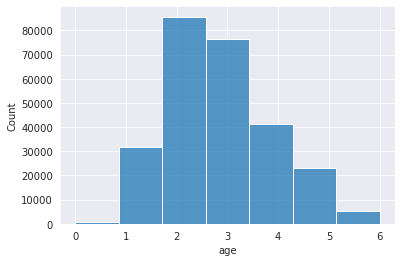

In [28]:
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(d_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

# Train/Val

In [29]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier(iterations=20000, one_hot_max_size=50, border_count=254)
clf.fit(x_train, y_train, verbose = False)

# Смотрим f1_weighted и total_score

In [30]:
f1_val_score = m.f1_score(y_test, clf.predict(x_test), average='weighted')
val_score += 2 * f1_val_score
print(f1_val_score)
print(val_score)

0.41004860879347177
1.4833116839112712


# To submit

In [31]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)

In [32]:
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']))

In [33]:
id_to_submit

user_id   is_male  age
0        221301  0.944070    2
1         31271  0.530147    3
2        211594  0.475509    2
3        253119  0.474049    2
4        192578  0.771562    2
...         ...       ...  ...
144719   415284  0.538200    2
144720   415285  0.514318    3
144721   415286  0.537249    3
144722   415306  0.516470    3
144723   415315  0.537692    3

[144724 rows x 3 columns]

In [34]:
id_to_submit.is_male.value_counts()

0.515317    36
0.490316    33
0.533008    33
0.486583    28
0.517056    27
            ..
0.571502     1
0.613461     1
0.989950     1
0.408859     1
0.537692     1
Name: is_male, Length: 142613, dtype: int64

In [35]:
id_to_submit.age.value_counts()

2    61110
3    56185
4    11543
1     9875
5     5900
6      111
Name: age, dtype: int64

In [36]:
id_to_submit.to_csv('submit.csv', index = False)